In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM,Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

## Read inputs and peek at the data

In [4]:
features = pd.read_csv("./data/features.csv")
power = pd.read_csv("./data/power.csv")

In [5]:
features.head()

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,...,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
0,2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,...,0.055473,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,5.732657,1.0,5.779913
1,2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,...,0.055473,0.267122,0.0,0.058617,-0.325738,-90.169106,-89.018669,5.813177,1.0,5.796757
2,2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,...,0.055473,0.267122,0.0,0.058617,-0.325738,-88.556343,-88.422020,5.786413,1.0,5.772958
3,2019-01-01 00:30:00,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,...,0.055473,0.267122,0.0,0.058617,-0.325738,-123.755341,-124.858444,5.758913,1.0,5.728393
4,2019-01-01 00:40:00,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,...,0.053982,0.267612,0.0,0.058703,-0.325443,-142.533325,-142.053543,5.724591,1.0,5.687730


In [6]:
power.head()

,Timestamp,Power(kW)
0,2019-01-01 00:00:00,705.876648
1,2019-01-01 00:10:00,884.711670
2,2019-01-01 00:20:00,982.875000
3,2019-01-01 00:30:00,1115.943359
4,2019-01-01 00:40:00,1263.841675


All the entries except Timestamp. Refer to [Documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) on how `iloc` works and [Stackoverflow](https://stackoverflow.com/a/56311678/15160666) for how it is used.

In [7]:
values = features.iloc[:, 1:].values

In [8]:
features = pd.DataFrame(values, columns=features.columns[1:])

In [9]:
#df["Timestamp"] = pd.to_datetime(df["Timestamp"]).apply(pd.Timestamp.timestamp) # pd.to_datetime(df["Timestamp"])
features

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,...,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
0,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,...,0.055473,0.267122,0.000000,0.058617,-0.325738,37.867054,39.281124,5.732657,1.0,5.779913
1,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,...,0.055473,0.267122,0.000000,0.058617,-0.325738,-90.169106,-89.018669,5.813177,1.0,5.796757
2,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,...,0.055473,0.267122,0.000000,0.058617,-0.325738,-88.556343,-88.422020,5.786413,1.0,5.772958
3,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,58.683334,...,0.055473,0.267122,0.000000,0.058617,-0.325738,-123.755341,-124.858444,5.758913,1.0,5.728393
4,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,59.623333,...,0.053982,0.267612,0.000000,0.058703,-0.325443,-142.533325,-142.053543,5.724591,1.0,5.687730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154257,65.811668,NaN,59.945000,62.808334,225.038239,65.300003,109.889709,61.000000,97.000000,62.808334,...,NaN,15.820095,15.199166,15.235223,14.540556,-29.340843,-27.513502,5.746916,1.0,5.756082
154258,68.586670,NaN,62.084999,65.413330,229.905838,67.871666,106.016670,61.116665,97.000000,65.413330,...,NaN,16.504293,15.876278,15.917643,15.207320,-31.925669,-30.197918,5.749150,1.0,5.755406
154259,63.746666,NaN,59.965000,64.051666,223.352631,64.461670,111.690208,61.293335,97.000000,64.050003,...,NaN,15.331903,14.720088,14.768394,14.064686,-53.071564,-48.306511,5.751807,1.0,5.747936
154260,66.643333,NaN,60.678333,63.421665,227.704514,66.081665,119.716499,60.786667,97.000000,63.421665,...,NaN,16.481724,15.887610,15.945046,15.230121,-28.747763,-23.844364,5.747686,1.0,5.757787


## Make a correlation map between features and generate a heatmap of it.

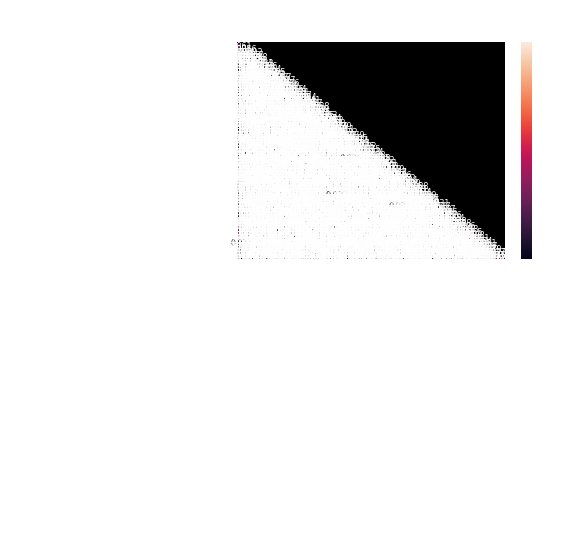

In [10]:
# Get rid of 1-1 matches to better highlight inter-feature correlations.
corrs = features.corr()
corrs.replace(1.0, corrs.min().min(), inplace=True)

# Upper-right triangle for masking
heatmap_mask = np.triu(corrs)

# Generate heatmap
heatmap = sns.heatmap(data=corrs, annot=True, vmin=0, vmax=corrs.max().max(), mask=heatmap_mask, annot_kws={"size":8})
heatmap.set_title("Coorelation Between Features", fontdict={"fontsize":24}, pad=16)
heatmap.set_autoscale_on(True)

Save the heatmap

In [14]:
fig = heatmap.get_figure()
fig.set_size_inches([84., 42.])
fig.savefig("./data/heatmap.png", bbox_inches="tight")

Line below outputs an array of `<AxesSubplot:>` objects. But the last 5 entries at the end do not have `title`.

array([[<AxesSubplot:title={'center':'Gearbox_T1_High_Speed_Shaft_Temperature'}>,
        <AxesSubplot:title={'center':'Gearbox_T3_High_Speed_Shaft_Temperature'}>,
        <AxesSubplot:title={'center':'Gearbox_T1_Intermediate_Speed_Shaft_Temperature'}>,
        <AxesSubplot:title={'center':'Temperature Gearbox Bearing Hollow Shaft'}>,
        <AxesSubplot:title={'center':'Tower Acceleration Normal'}>,
        <AxesSubplot:title={'center':'Gearbox_Oil-2_Temperature'}>,
        <AxesSubplot:title={'center':'Tower Acceleration Lateral'}>,
        <AxesSubplot:title={'center':'Temperature Bearing_A'}>,
        <AxesSubplot:title={'center':'Temperature Trafo-3'}>],
       [<AxesSubplot:title={'center':'Gearbox_T3_Intermediate_Speed_Shaft_Temperature'}>,
        <AxesSubplot:title={'center':'Gearbox_Oil-1_Temperature'}>,
        <AxesSubplot:title={'center':'Gearbox_Oil_Temperature'}>,
        <AxesSubplot:title={'center':'Torque'}>,
        <AxesSubplot:title={'center':'Converter Control Un

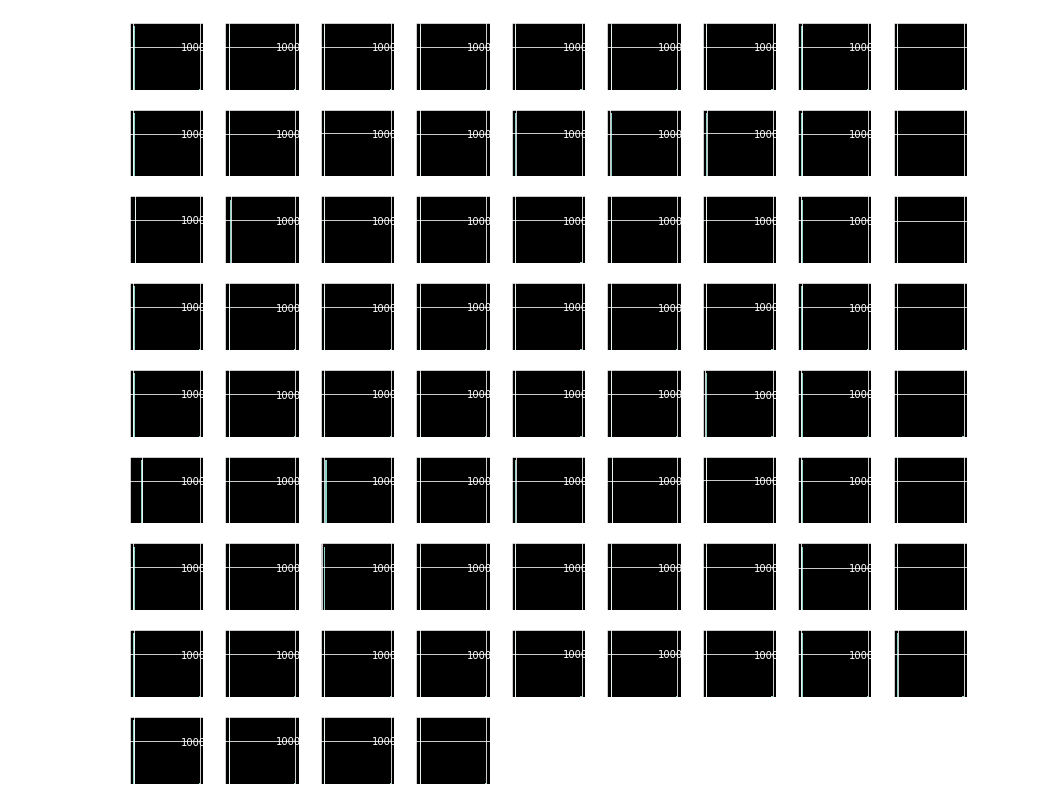

In [15]:
features.hist(bins=50, figsize=(15,14))

In [ ]:
updated_features = features.fillna(method='ffill').fillna(method='bfill')
updated_features.isnull().sum()

Timestamp                                          0
Gearbox_T1_High_Speed_Shaft_Temperature            0
Gearbox_T3_High_Speed_Shaft_Temperature            0
Gearbox_T1_Intermediate_Speed_Shaft_Temperature    0
Temperature Gearbox Bearing Hollow Shaft           0
                                                  ..
Moment Q Direction                                 0
Moment Q Filltered                                 0
Proxy Sensor_Degree-45                             0
Turbine State                                      0
Proxy Sensor_Degree-315                            0
Length: 77, dtype: int64

####Merge csv files

In [ ]:
merged = updated_features.merge(power, on='Timestamp')
merged.to_csv("final.csv", index=False)

In [ ]:
merged

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature_x,Gearbox_T3_High_Speed_Shaft_Temperature_x,Gearbox_T1_Intermediate_Speed_Shaft_Temperature_x,Temperature Gearbox Bearing Hollow Shaft_x,Tower Acceleration Normal_x,Gearbox_Oil-2_Temperature_x,Tower Acceleration Lateral_x,Temperature Bearing_A_x,Temperature Trafo-3_x,...,Blade-1 Actual Value_Angle-A_y,Blade-2 Set Value_Degree_y,Pitch Demand Baseline_Degree_y,Blade-1 Set Value_Degree_y,Blade-3 Set Value_Degree_y,Moment Q Direction_y,Moment Q Filltered_y,Proxy Sensor_Degree-45_y,Turbine State_y,Proxy Sensor_Degree-315_y
0,2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,...,0.055473,0.267122,0.000000,0.058617,-0.325738,37.867054,39.281124,5.732657,1.000000,5.779913
1,2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,...,0.055473,0.267122,0.000000,0.058617,-0.325738,-90.169106,-89.018669,5.813177,1.000000,5.796757
2,2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,...,0.055473,0.267122,0.000000,0.058617,-0.325738,-88.556343,-88.422020,5.786413,1.000000,5.772958
3,2019-01-01 00:30:00,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,...,0.055473,0.267122,0.000000,0.058617,-0.325738,-123.755341,-124.858444,5.758913,1.000000,5.728393
4,2019-01-01 00:40:00,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,...,0.053982,0.267612,0.000000,0.058703,-0.325443,-142.533325,-142.053543,5.724591,1.000000,5.687730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,2019-01-22 10:30:00,40.000000,42.000000,38.000000,44.000000,12.146410,43.000000,6.835217,20.198334,46.000000,...,0.088269,0.249458,0.000000,0.094110,-0.343566,14.779414,14.866619,5.924689,1.000000,5.957480
3067,2019-01-22 10:40:00,40.000000,42.000000,38.000000,44.000000,15.894386,43.000000,6.993409,21.000000,46.000000,...,0.845955,0.988809,0.772196,0.853915,0.473866,12.466055,12.666699,5.934547,1.263333,5.965878
3068,2019-01-22 10:50:00,40.000000,42.000000,38.000000,43.505001,22.044817,42.256668,16.596987,21.000000,46.000000,...,32.073120,32.137619,32.054882,32.086094,31.940359,9.183112,9.838683,5.925813,2.340000,5.955786
3069,2019-01-22 11:00:00,39.553333,41.341667,37.911667,43.000000,11.381814,42.000000,3.295669,21.000000,46.000000,...,65.004669,65.000000,65.000000,65.000000,65.000000,13.687778,13.590713,5.890428,3.000000,5.930488


In [ ]:
merged.columns

Index(['Timestamp', 'Gearbox_T1_High_Speed_Shaft_Temperature_x',
       'Gearbox_T3_High_Speed_Shaft_Temperature_x',
       'Gearbox_T1_Intermediate_Speed_Shaft_Temperature_x',
       'Temperature Gearbox Bearing Hollow Shaft_x',
       'Tower Acceleration Normal_x', 'Gearbox_Oil-2_Temperature_x',
       'Tower Acceleration Lateral_x', 'Temperature Bearing_A_x',
       'Temperature Trafo-3_x',
       ...
       'Blade-1 Actual Value_Angle-A_y', 'Blade-2 Set Value_Degree_y',
       'Pitch Demand Baseline_Degree_y', 'Blade-1 Set Value_Degree_y',
       'Blade-3 Set Value_Degree_y', 'Moment Q Direction_y',
       'Moment Q Filltered_y', 'Proxy Sensor_Degree-45_y', 'Turbine State_y',
       'Proxy Sensor_Degree-315_y'],
      dtype='object', length=153)

In [ ]:
merged["Timestamp"] = pd.to_datetime(merged["Timestamp"])

In [ ]:
merged["Timestamp"]

0      2019-01-01 00:00:00
1      2019-01-01 00:10:00
2      2019-01-01 00:20:00
3      2019-01-01 00:30:00
4      2019-01-01 00:40:00
               ...        
3066   2019-01-22 10:30:00
3067   2019-01-22 10:40:00
3068   2019-01-22 10:50:00
3069   2019-01-22 11:00:00
3070   2019-01-22 11:10:00
Name: Timestamp, Length: 3071, dtype: datetime64[ns]

In [ ]:
merged["Timestamp"].dt.dayofweek

0       1
1       1
2       1
3       1
4       1
       ..
3066    1
3067    1
3068    1
3069    1
3070    1
Name: Timestamp, Length: 3071, dtype: int64

In [ ]:
# get one hot encoding
ohe = pd.get_dummies(merged['Timestamp'])
merged = merged.join(ohe)
date = pd.to_datetime(merged.pop('Timestamp'))


In [ ]:
date

0      2019-01-01 00:00:00
1      2019-01-01 00:10:00
2      2019-01-01 00:20:00
3      2019-01-01 00:30:00
4      2019-01-01 00:40:00
               ...        
3066   2019-01-22 10:30:00
3067   2019-01-22 10:40:00
3068   2019-01-22 10:50:00
3069   2019-01-22 11:00:00
3070   2019-01-22 11:10:00
Name: Timestamp, Length: 3071, dtype: datetime64[ns]

In [ ]:
merged.head()

,Gearbox_T1_High_Speed_Shaft_Temperature_x,Gearbox_T3_High_Speed_Shaft_Temperature_x,Gearbox_T1_Intermediate_Speed_Shaft_Temperature_x,Temperature Gearbox Bearing Hollow Shaft_x,Tower Acceleration Normal_x,Gearbox_Oil-2_Temperature_x,Tower Acceleration Lateral_x,Temperature Bearing_A_x,Temperature Trafo-3_x,Gearbox_T3_Intermediate_Speed_Shaft_Temperature_x,...,2019-01-22 09:40:00,2019-01-22 09:50:00,2019-01-22 10:00:00,2019-01-22 10:10:00,2019-01-22 10:20:00,2019-01-22 10:30:00,2019-01-22 10:40:00,2019-01-22 10:50:00,2019-01-22 11:00:00,2019-01-22 11:10:00
0,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,...,0,0,0,0,0,0,0,0,0,0
1,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,...,0,0,0,0,0,0,0,0,0,0
2,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,...,0,0,0,0,0,0,0,0,0,0
3,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,58.683334,...,0,0,0,0,0,0,0,0,0,0
4,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,59.623333,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Date object is string format so we can t use we need to change in day, month and year(just 2019 so doesn t necessary) format
import datetime
timestamp_s = date.map(datetime.datetime.timestamp)

In [ ]:
day = 24*60*60
month = day*12
year = (365.2425)*day

merged['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
merged['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
merged['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
merged['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
merged['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
merged['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

No handles with labels found to put in legend.


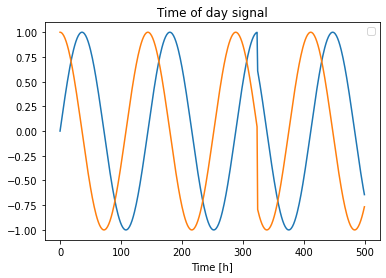

In [ ]:
plt.plot(np.array(merged['Day sin'])[:500])
plt.plot(np.array(merged['Day cos'])[:500])
plt.xlabel('Time [h]')
plt.title('Time of day signal')


In [ ]:
merged.head()

,Gearbox_T1_High_Speed_Shaft_Temperature_x,Gearbox_T3_High_Speed_Shaft_Temperature_x,Gearbox_T1_Intermediate_Speed_Shaft_Temperature_x,Temperature Gearbox Bearing Hollow Shaft_x,Tower Acceleration Normal_x,Gearbox_Oil-2_Temperature_x,Tower Acceleration Lateral_x,Temperature Bearing_A_x,Temperature Trafo-3_x,Gearbox_T3_Intermediate_Speed_Shaft_Temperature_x,...,2019-01-22 10:40:00,2019-01-22 10:50:00,2019-01-22 11:00:00,2019-01-22 11:10:00,Day sin,Day cos,Month sin,Month cos,Year sin,Year cos
0,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,...,0,0,0,0,-5.030095e-12,1.000000,0.500000,-0.866025,0.002021,0.999998
1,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,...,0,0,0,0,4.361939e-02,0.999048,0.496848,-0.867838,0.002141,0.999998
2,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,...,0,0,0,0,8.715574e-02,0.996195,0.493689,-0.869639,0.002260,0.999997
3,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,58.683334,...,0,0,0,0,1.305262e-01,0.991445,0.490524,-0.871428,0.002380,0.999997
4,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,59.623333,...,0,0,0,0,1.736482e-01,0.984808,0.487352,-0.873206,0.002499,0.999997


In [ ]:
merged['Gearbox_Temperature_Average'] = merged[["Gearbox_T1_High_Speed_Shaft_Temperature_x","Gearbox_T3_High_Speed_Shaft_Temperature_x"]].mean(axis=1)

In [ ]:
merged

,Gearbox_T1_High_Speed_Shaft_Temperature_x,Gearbox_T3_High_Speed_Shaft_Temperature_x,Gearbox_T1_Intermediate_Speed_Shaft_Temperature_x,Temperature Gearbox Bearing Hollow Shaft_x,Tower Acceleration Normal_x,Gearbox_Oil-2_Temperature_x,Tower Acceleration Lateral_x,Temperature Bearing_A_x,Temperature Trafo-3_x,Gearbox_T3_Intermediate_Speed_Shaft_Temperature_x,...,2019-01-22 10:50:00,2019-01-22 11:00:00,2019-01-22 11:10:00,Day sin,Day cos,Month sin,Month cos,Year sin,Year cos,Gearbox_Temperature_Average
0,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,...,0,0,0,-5.030095e-12,1.000000,0.500000,-0.866025,0.002021,0.999998,58.000000
1,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,...,0,0,0,4.361939e-02,0.999048,0.496848,-0.867838,0.002141,0.999998,58.589167
2,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,...,0,0,0,8.715574e-02,0.996195,0.493689,-0.869639,0.002260,0.999997,59.878334
3,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,58.683334,...,0,0,0,1.305262e-01,0.991445,0.490524,-0.871428,0.002380,0.999997,60.722500
4,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,59.623333,...,0,0,0,1.736482e-01,0.984808,0.487352,-0.873206,0.002499,0.999997,61.938334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,40.000000,42.000000,38.000000,44.000000,12.146410,43.000000,6.835217,20.198334,46.000000,44.000000,...,0,0,0,3.826834e-01,-0.923880,0.956940,0.290285,0.362367,0.932036,41.000000
3067,40.000000,42.000000,38.000000,44.000000,15.894386,43.000000,6.993409,21.000000,46.000000,44.000000,...,0,0,0,3.420201e-01,-0.939693,0.957990,0.286803,0.362478,0.931992,41.000000
3068,40.000000,42.000000,38.000000,43.505001,22.044817,42.256668,16.596987,21.000000,46.000000,43.503334,...,1,0,0,3.007058e-01,-0.953717,0.959026,0.283318,0.362589,0.931949,41.000000
3069,39.553333,41.341667,37.911667,43.000000,11.381814,42.000000,3.295669,21.000000,46.000000,43.000000,...,0,1,0,2.588190e-01,-0.965926,0.960050,0.279829,0.362701,0.931906,40.447500


In [ ]:
column_indices = {name: i for i, name in enumerate(merged.columns)}

In [ ]:
column_indices

In [ ]:
n = len(merged)
train_merged = merged[0:int(n*0.7)]
val_merged = merged[int(n*0.7):int(n*0.9)]
test_merged = merged[int(n*0.9):]

num_features = merged.shape[1]

#Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_merged = sc.fit_transform(train_merged)
test_merged = sc.transform(test_merged)
val_merged = sc.transform(val_merged)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
merged.info() 
'''
  1) #sns heatmap ---> correlation 
  1.5) # en önemli featureların ne olduğu hakkında araştırma yapılacak.
  2) 77 ---> 40-50 #sns plot ->>
  3) #optimization, steepest descent algorithm, rulet(random) ,
  4) #feature reduction, 
  #feaure ,, Correlation incelenecek + null değerler doldurulacak 
  5) information theory --> bilgi teorisi (shannon) -- i*logi = # algoritmalarında en büyük en küçük logaritmasını  
  2) değeri -->ağırlıklı bir şekilde birleştirme
'''


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27271 entries, 0 to 27270
Data columns (total 78 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Timestamp                                          27271 non-null  object 
 1   Gearbox_T1_High_Speed_Shaft_Temperature            26716 non-null  float64
 2   Gearbox_T3_High_Speed_Shaft_Temperature            26429 non-null  float64
 3   Gearbox_T1_Intermediate_Speed_Shaft_Temperature    26467 non-null  float64
 4   Temperature Gearbox Bearing Hollow Shaft           26599 non-null  float64
 5   Tower Acceleration Normal                          26430 non-null  float64
 6   Gearbox_Oil-2_Temperature                          26120 non-null  float64
 7   Tower Acceleration Lateral                         26661 non-null  float64
 8   Temperature Bearing_A                              26660 non-null  float64
 9   Temper

In [ ]:
import seaborn as sns
sns.heatmap(merged)

TypeError: ignored

In [ ]:
merged.describe()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,...,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315,Power(kW)
count,26716.000000,26429.000000,26467.000000,26599.000000,26430.000000,26120.000000,26661.000000,26660.000000,26533.000000,26635.000000,...,26525.000000,26249.000000,26652.000000,26677.000000,26494.000000,26255.000000,26673.000000,26685.000000,26637.000000,27271.000000
mean,659.090620,788.393585,839.029423,853.998969,973.442923,788.266091,693.396706,627.215451,832.793801,680.434175,...,688.375157,698.657407,827.460704,713.751162,739.703113,785.094381,643.111252,724.610098,651.503369,1072.971122
std,7759.342035,8531.532657,8846.819896,8908.041934,9479.857752,8537.553361,8072.262649,7672.922481,8772.129958,7889.265526,...,8186.061726,8251.538996,8985.391487,8342.084084,8657.196018,8909.193284,7957.537541,8473.574413,8009.277752,1045.673221
min,15.000000,16.000000,14.000000,17.000000,0.000000,14.000000,0.000000,6.000000,23.000000,17.000000,...,-0.128618,0.000000,-0.766988,-1.050195,-1287.386719,-1286.707886,5.460515,1.000000,5.339908,-48.596668
25%,44.000000,46.000000,41.758335,47.743332,25.130543,46.000000,17.948212,28.000000,50.361668,48.000000,...,0.255701,0.000000,0.114964,-0.353234,-38.828705,-38.641741,5.747502,1.000000,5.761202,78.562500
50%,56.459999,58.000000,52.291668,55.000000,51.244709,55.674166,33.431263,34.000000,55.213333,55.000000,...,0.739858,0.142326,0.510179,-0.069154,-11.820730,-11.601585,5.803892,1.000000,5.823047,709.484985
75%,63.003334,65.120003,58.916668,61.927500,88.266958,63.000000,50.067799,41.000000,62.000000,61.984167,...,12.051938,11.122175,11.828796,11.153019,15.863569,16.004818,5.870070,1.000000,5.907902,2117.644897
max,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,...,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,2779.423340


In [ ]:
merged["Timestamp"] = pd.to_datetime(merged["Timestamp"])

In [ ]:
merged_train = merged.iloc[:, 77:78].values

In [ ]:
merged_train

array([[ 705.87664795],
       [ 884.71166992],
       [ 982.875     ],
       ...,
       [1435.43505859],
       [ 982.97998047],
       [ 953.58502197]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
train_set_with_s = ms.fit_transform(merged) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
X_train = []
y_train = []

for i in range(50,len(train_set_with_s)):
  X_train.append(train_set_with_s[i-50:i, 0])
  y_train.append(train_set_with_s[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#importing keras libraries and packages
from keras.models import Sequential
from keras.layers import LSTM,Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

In [ ]:
model.add(LSTM(units=20, activation="selu", return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) #hyperparameter tuning -- GridSearch, #Dimensionality reduciton(PCa,regularization, )


In [ ]:
model.add(LSTM(units=30, activation="selu",return_sequences=True ))
model.add(Dropout(0.2))

In [ ]:
model.add(LSTM(units=40, activation="selu", return_sequences=True))
model.add(Dropout(0.3))

In [ ]:
model.add(LSTM(units=50, activation="selu"))
model.add(Dropout(0.3))

In [ ]:
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

In [ ]:
model.fit(x=X_train, y=y_train, epochs = 30, batch_size=64, verbose = 1, callbacks=[earlyStopping], validation_split=0.2)

Epoch 1/30
38/38 [==============================] - 6s 164ms/step - loss: 0.0099 - val_loss: 0.0040
Epoch 2/30
38/38 [==============================] - 4s 115ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 3/30
38/38 [==============================] - 4s 115ms/step - loss: 0.0093 - val_loss: 0.0045
Epoch 4/30
38/38 [==============================] - 4s 114ms/step - loss: 0.0095 - val_loss: 0.0037
Epoch 5/30
38/38 [==============================] - 4s 115ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 6/30
38/38 [==============================] - 4s 116ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 7/30
38/38 [==============================] - 4s 116ms/step - loss: 0.0092 - val_loss: 0.0035
Epoch 8/30
38/38 [==============================] - 4s 116ms/step - loss: 0.0088 - val_loss: 0.0033
Epoch 9/30
38/38 [==============================] - 4s 115ms/step - loss: 0.0089 - val_loss: 0.0036
Epoch 10/30
38/38 [==============================] - 4s 117ms/step - loss: 0.0090 - val_loss: 0.0039

In [ ]:
pred_df = pd.read_csv("/content/sample_submission.csv")